# comparison of overlay with EventWeight to Beam-On data
## when cosmic are not rescaled - i.e. POT normalization of the MC to the 4.9e19POT in the data

In [5]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
import json

%matplotlib inline

In [3]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/EventWeight/'

In [4]:
versions['overlay date'] = '2018_07_10'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [10]:
path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/'
prefix = path+versions['Overlay']+'_'+versions['overlay date']+'_'
selected_overlay=dict()

if os.path.isfile(prefix+'selected_cc1p0pi.csv'): 
    for pair_type in pair_types:
        selected_overlay[pair_type]=pd.read_csv(prefix+'selected_'+pair_type+'.csv')
    selected_CC1p0pi=pd.read_csv(prefix+'selected_cc1p0pi.csv')
    overlay_scaling = json.load(open(prefix+"overlay_scaling_POT.txt"))


else:
    OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
    cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
    reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
    print 'applied cuts to overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
    selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
    print len(selected_overlay_concat),'events in the overlay'
    selected_cc1p0pi = selected_overlay['CC 1p 0pi']
    print len(selected_cc1p0pi),'selected CC 1p 0pi pairs in overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type].to_csv(prefix+'selected_'+pair_type+'.csv')
    selected_cc1p0pi.to_csv(prefix+'selected_cc1p0pi.csv')
    print 'output to ',figures_path,'.csv'
    
    # overlay scaling
    summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')
    Nevents['OnBeam POT'] = 4.908e+19
    Nevents['overlay']      = np.sum(summary.Nevents)
    Nevents['overlay POT']  = np.sum(summary.POT)
    Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']
    overlay_scaling = get_samples_scaling( N_total='MC(tot) x POT', debug=0, OverlaySubsamples=OverlaySamples, f_POT=Nevents['f(POT)'])
    filename = prefix+"overlay_scaling_POT.txt"
    json.dump(overlay_scaling, open(filename,'w'))
    print 'saved scaling into',filename

In [11]:
selected_events=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_events.csv')

## compare the shapes and rates after the event-selection cuts

In [14]:
mA_array = [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
mA_names = ['040','070','080','095','099','100','110','115','135','171']

# compare using Likelihood
The way we do it is by separating Likelihood to the number of events $\times$ the likelihood to the shape
$$ \hat l(data \; | \;m_A) = l(N_{data} \; | \;m_A-integral) \times l(data \; | \;m_A-shape)
$$
where 
$$
l(N_{data} \; | \;m_A-integral) = P_{Poisson} (N_{data} \; | \; \int dQ^2 (m_A))
$$

assuming a Poisson distribution for the number of events with $m_A$ as input $I_{m_A} = \int dQ^2 (m_A)$, 

$$
    l(N_{data} \; | \;m_A-integral) 
    = \frac{e^{-{I_{m_A}}}}{(N_{data})!} (I_{m_A})^{N_{data}} 
    \sim
    \frac{e^{N_{data}-{I_{m_A}}}}{ \sqrt{2\pi N_{data}} } \left(\frac{I_{m_A}}{N_{data}}\right)^{N_{data}}
$$



In [15]:
from scipy.stats import distributions
from pyqt_fit import kde

Warning, cannot import Cython kernel functions, pure python functions will be used instead


In [16]:
pdf_dict = dict()
mc = selected_overlay_concat
mc_array = np.array(mc['reco_Q2'])

kde1d_pdf,weighted_pdf=dict(),dict()
for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])    
    weighted_pdf[mA] = kde.KDE1D(mc_array, weights=mc_weights, bandwidth=.01)
    kde1d_pdf[mA] = kde.KDE1D(mc_array, bandwidth=.01)
print 'done creating pdfs.'

done creating pdfs.


In [17]:
data_time = Nevents['f(POT)']
data = selected_events
data_array = np.array(data['reco_Q2'])
N_data = float(len(data_array))

I_mc,I_mc_normalized,P_poisson = dict(),dict(),dict()
results = pd.DataFrame(columns=mA_array)
P_integral_arr,LL_integral_arr,LL_pdf_arr,LL_arr = [],[],[],[]

for mA,name in zip(mA_array,mA_names):
    mc_weights = np.array(mc['evwgh_mA'+name+'_Genie'])    
    I_mc[mA] = np.sum(mc_weights)
    I_mc_normalized[mA] = I_mc[mA]*data_time    
    P_poisson[mA] = distributions.poisson.pmf(N_data , I_mc_normalized[mA])    
    P_integral_arr.append(P_poisson[mA])
    
    LL_integral = np.log(P_poisson[mA])
    LL_integral_arr.append(LL_integral)
    
    P_pdf = weighted_pdf[mA](data_array)
    LL_pdf = np.sum(np.log(P_pdf))
    LL_pdf_arr.append(LL_pdf)
    
    LL = LL_integral + LL_pdf
    LL_arr.append(LL) 
    
print 'done comparing %d data events to different GENIE weights.'%N_data

done comparing 350 data events to different GENIE weights.


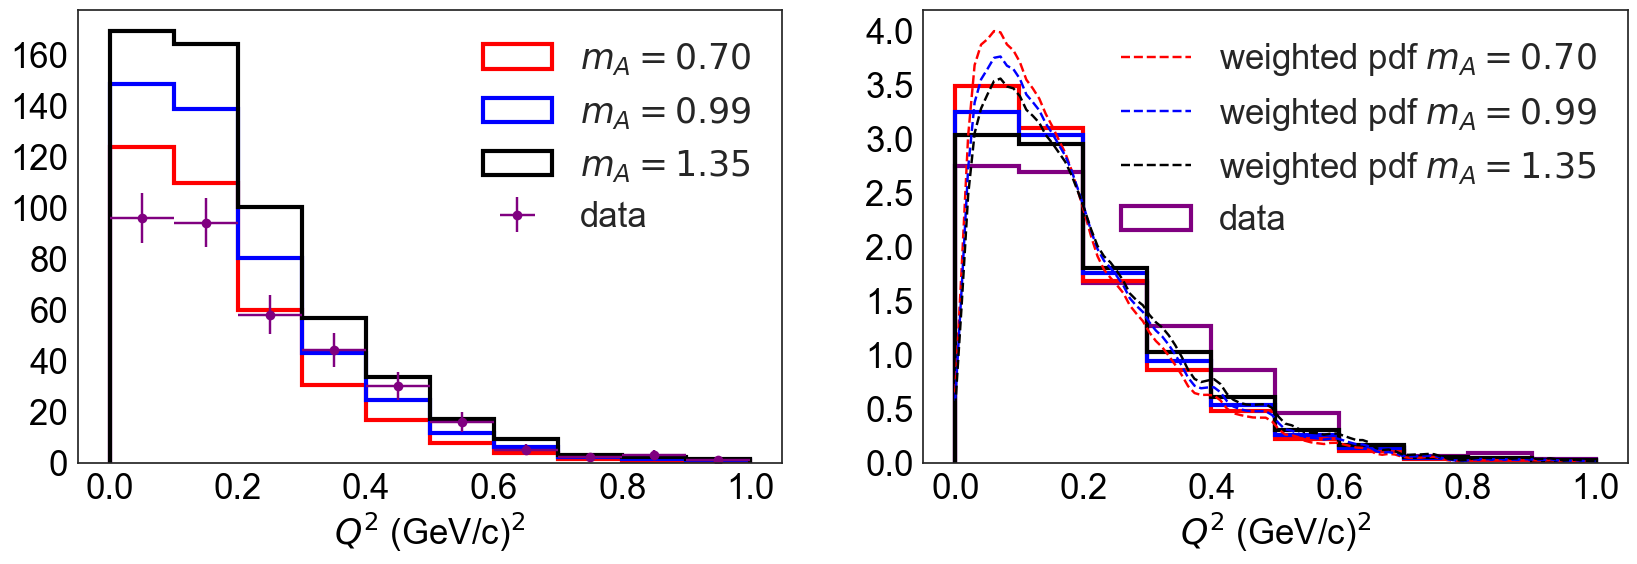

In [38]:
xs = linspace(0,1,100)
bins=linspace(0,1,11)
fig=plt.figure(figsize=(20,6));
ax = fig.add_subplot(1,2,1)
# h,bins,_=plt.hist(data_array  ,bins=bins, label=None,histtype='step',linewidth=3,color='purple')
plt.errorbar(x=0.5*(bins[1:]+bins[:-1]),xerr=0.5*(bins[1]-bins[0]),y=h, yerr=np.sqrt(h), fmt='o' ,label='data',color='purple',ecolor='purple')
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135'],['red','blue','black']):
    plt.hist(mc_array , weights=np.array(mc['evwgh_mA'+name+'_Genie'])*Nevents['f(POT)'] ,bins=bins, label='$m_A=%.2f$'%mA,histtype='step',linewidth=3,color=color)
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True,legend_loc='best')

ax = fig.add_subplot(1,2,2)
plt.hist(data_array  ,bins=bins, label='data', normed=1,histtype='step',linewidth=3,color='purple')
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135'],['red','blue','black']):
    plt.hist(mc_array , weights=np.array(mc['evwgh_mA'+name+'_Genie']) ,bins=bins, label=None, normed=1,histtype='step',linewidth=3,color=color)
    plt.plot(xs, weighted_pdf[mA](xs),'--', label='weighted pdf $m_A=%.2f$'%mA,color=color)
set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True,legend_loc='best')




$m_A=0.63^{+0.15}_{-1.63}$ GeV/c$^2$


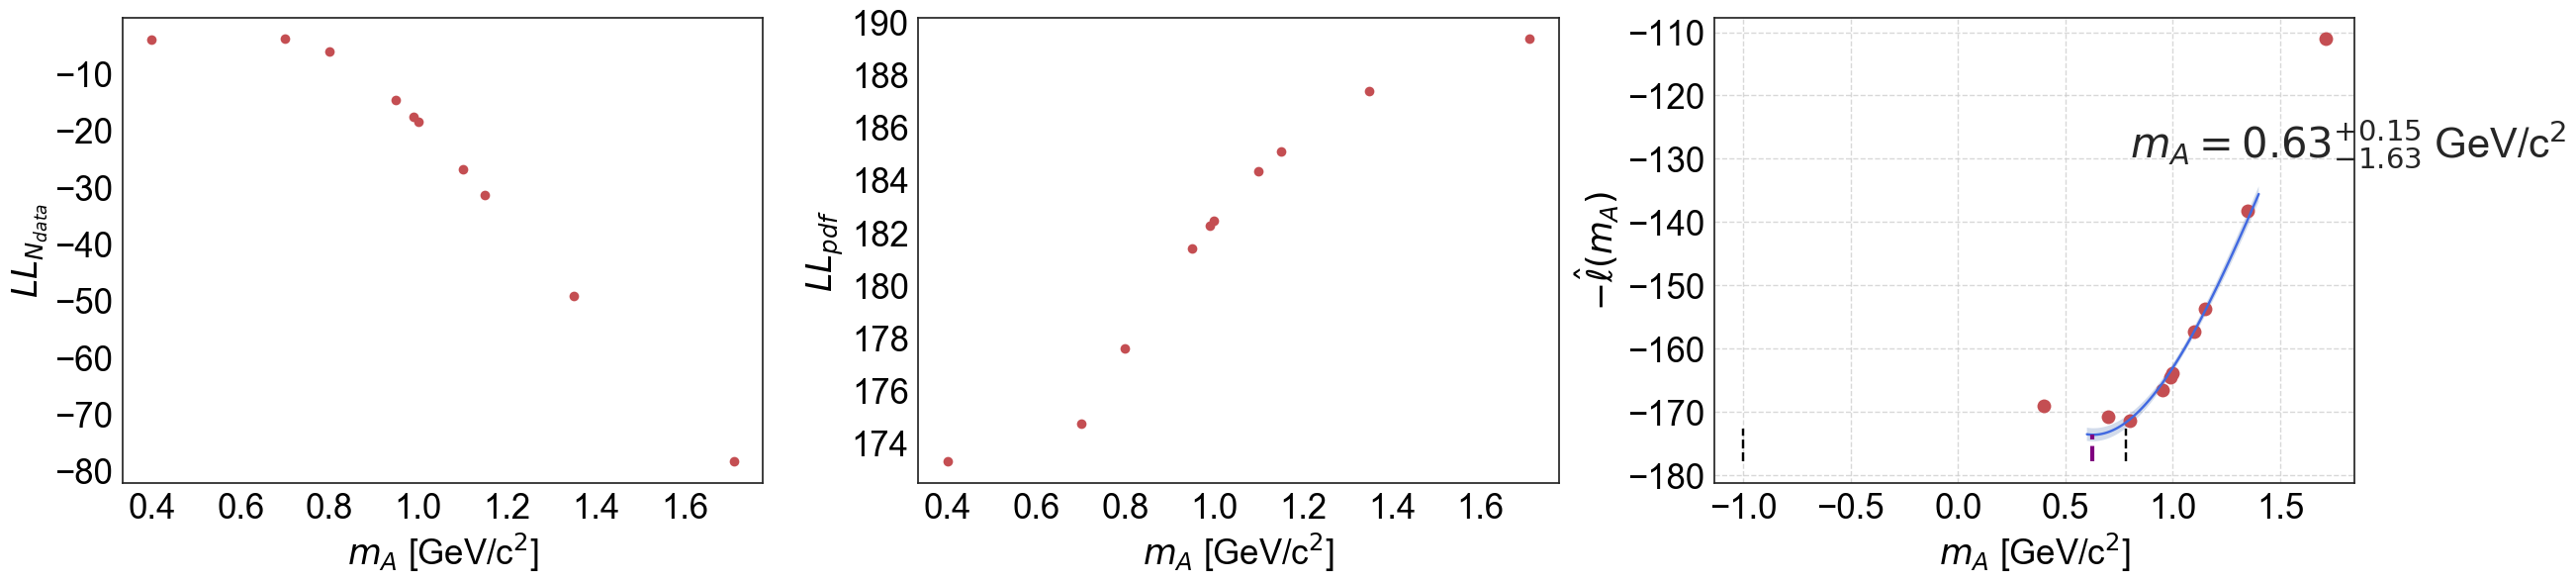

In [18]:
fig=plt.figure(figsize=(24,6));
ax = fig.add_subplot(1,3,1)
plt.errorbar(x=mA_array,y=LL_integral_arr,fmt='ro',color='black')
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$LL_{N_{data}}$')

ax = fig.add_subplot(1,3,2)
plt.errorbar(x=mA_array,y=LL_pdf_arr,fmt='ro',color='black')
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$LL_{pdf}$')


ax = fig.add_subplot(1,3,3)

x,y = mA_array , -np.array(LL_arr)
deg = 3
p,cov = np.polyfit(x,y,deg=deg,cov=True)
poly = np.poly1d(p)    
plt.plot( x,y , 'ro',markersize=10,linewidth=2,label='LL')
x_poly = linspace(0.6,1.4,100)
y_poly = poly(x_poly)
y_MLE = np.min(poly(x_poly))
x_MLE = find_x_poly(poly,y_MLE,xmin=0.6,xmax=1.4)

plt.plot(x_poly,y_poly,'-',color='royalblue',label='polynomial fit')    

# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([x_poly**(deg-i) for i in range(deg+1)]).T
Cov_poly = np.dot(TT, np.dot(cov, TT.T)) # C_y = TT*C_z*TT.T
sig_poly = np.sqrt(np.diag(Cov_poly))  # Standard deviations are sqrt of diagonal
poly_up = np.poly1d(np.polyfit(x_poly,poly(x_poly)+sig_poly,deg=deg))
poly_dw = np.poly1d(np.polyfit(x_poly,poly(x_poly)-sig_poly,deg=deg))
ax.fill_between(x_poly, poly(x_poly)+sig_poly, poly(x_poly)-sig_poly, alpha=.25)

TT_x_MLE = np.vstack([np.array([x_MLE])**(deg-i) for i in range(deg+1)]).T
Cov_MLE = np.dot(TT_x_MLE, np.dot(cov, TT_x_MLE.T)) # C_y = TT*C_z*TT.T
sig_MLE = np.sqrt(np.diag(Cov_MLE))  # Standard deviations are sqrt of diagonal
MLE_top = y_MLE + sig_MLE

ymin = np.min(ax.get_ylim())
plt.plot([x_MLE,x_MLE],[ymin,y_MLE],'--',linewidth=3,color='purple',label='MLE')
MLE = poly(x_MLE)
x_MLE_dw = find_x_poly(poly_dw,MLE_top,xmin=0.6,xmax=x_MLE); x_MLE_dw_err = x_MLE - x_MLE_dw
x_MLE_up = find_x_poly(poly_dw,MLE_top,xmin=x_MLE,xmax=1.4); x_MLE_up_err = x_MLE_up - x_MLE
plt.plot(        
        [x_MLE_dw,x_MLE_dw],[ymin,MLE_top],'--'
        ,[x_MLE_up,x_MLE_up],[ymin,MLE_top],'--'
#         ,[x_MLE_dw,x_MLE_up],[MLE_top,MLE_top],'-'
        ,color='black',label='68.3% confidence')
string = '$m_A=%.2f^{+%.2f}_{-%.2f}$ GeV/c$^2$'%(x_MLE,x_MLE_up_err,x_MLE_dw_err)
print string
plt.text(0.8,np.min(ax.get_ylim())+0.7*(np.max(ax.get_ylim())-np.min(ax.get_ylim())),string,fontsize=30)
set_axes(ax,r'$m_A$ [GeV/c$^2$]','$-{\hat {\ell }}(m_{A})$',do_add_grid=True)
plt.tight_layout()

# compare using $\chi^2$

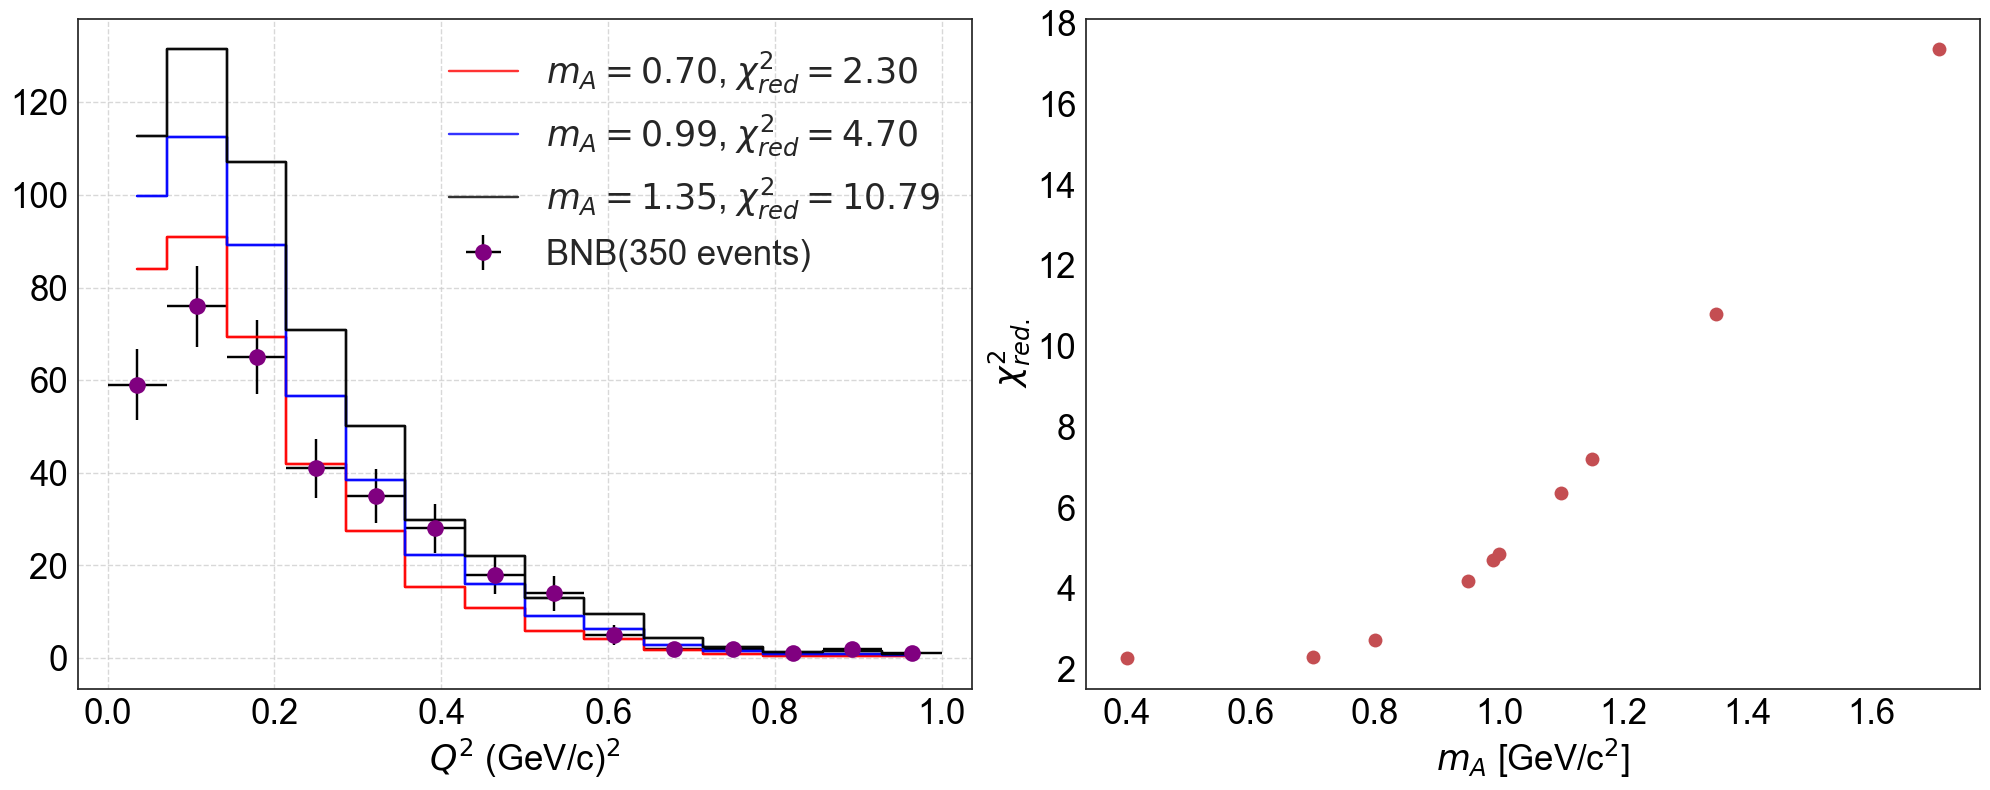

In [12]:
var,x_label = 'reco_Q2', r'$Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)

fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135','171'],['red','blue','black','forestgreen']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , ax=ax, overlay_scaling=overlay_scaling
                                                   , var=var
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , var=var
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,''#,ylim=(0,1.2*np.max(h_OnBeam+h_OnBeam_err))
         ,do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, do_draw=False, overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

# What is the contribution of MEC to the events-distribution? 

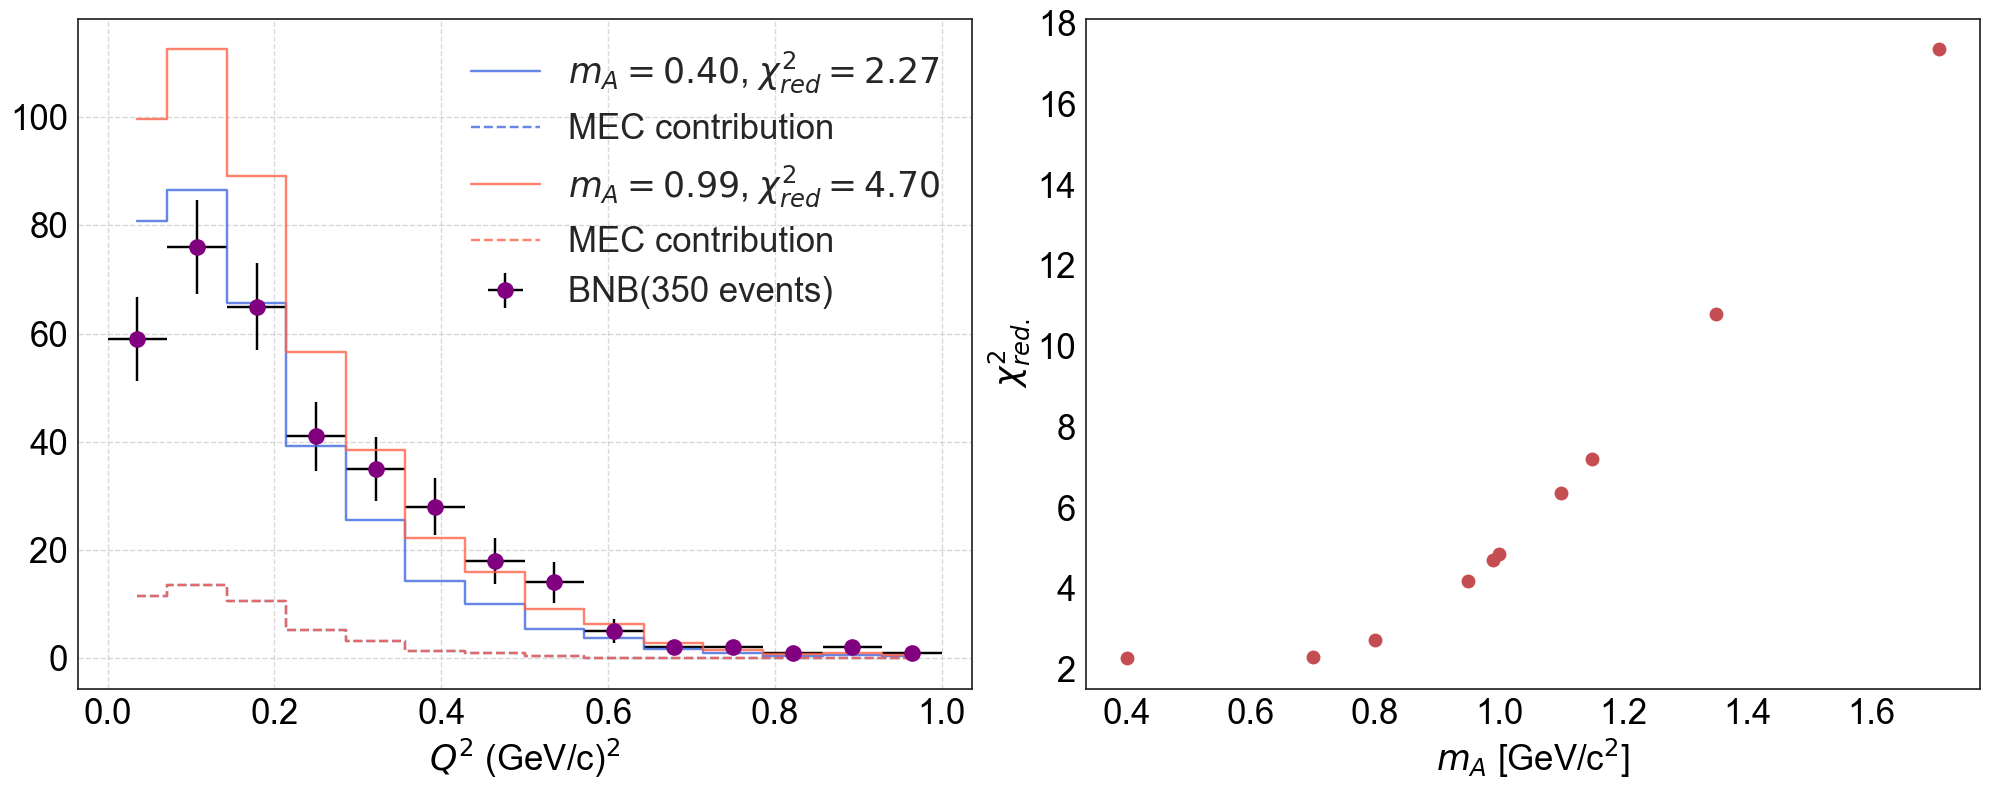

In [32]:
var,x_label = 'reco_Q2', r'$Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)

fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    

for mA,name,color in zip([0.4,0.99],['040','099'],['royalblue','tomato']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc,do_draw=False, overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc, var=var,do_add_MEC_contribution=True
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, do_draw=False, overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

# compare as a function of $p_p$

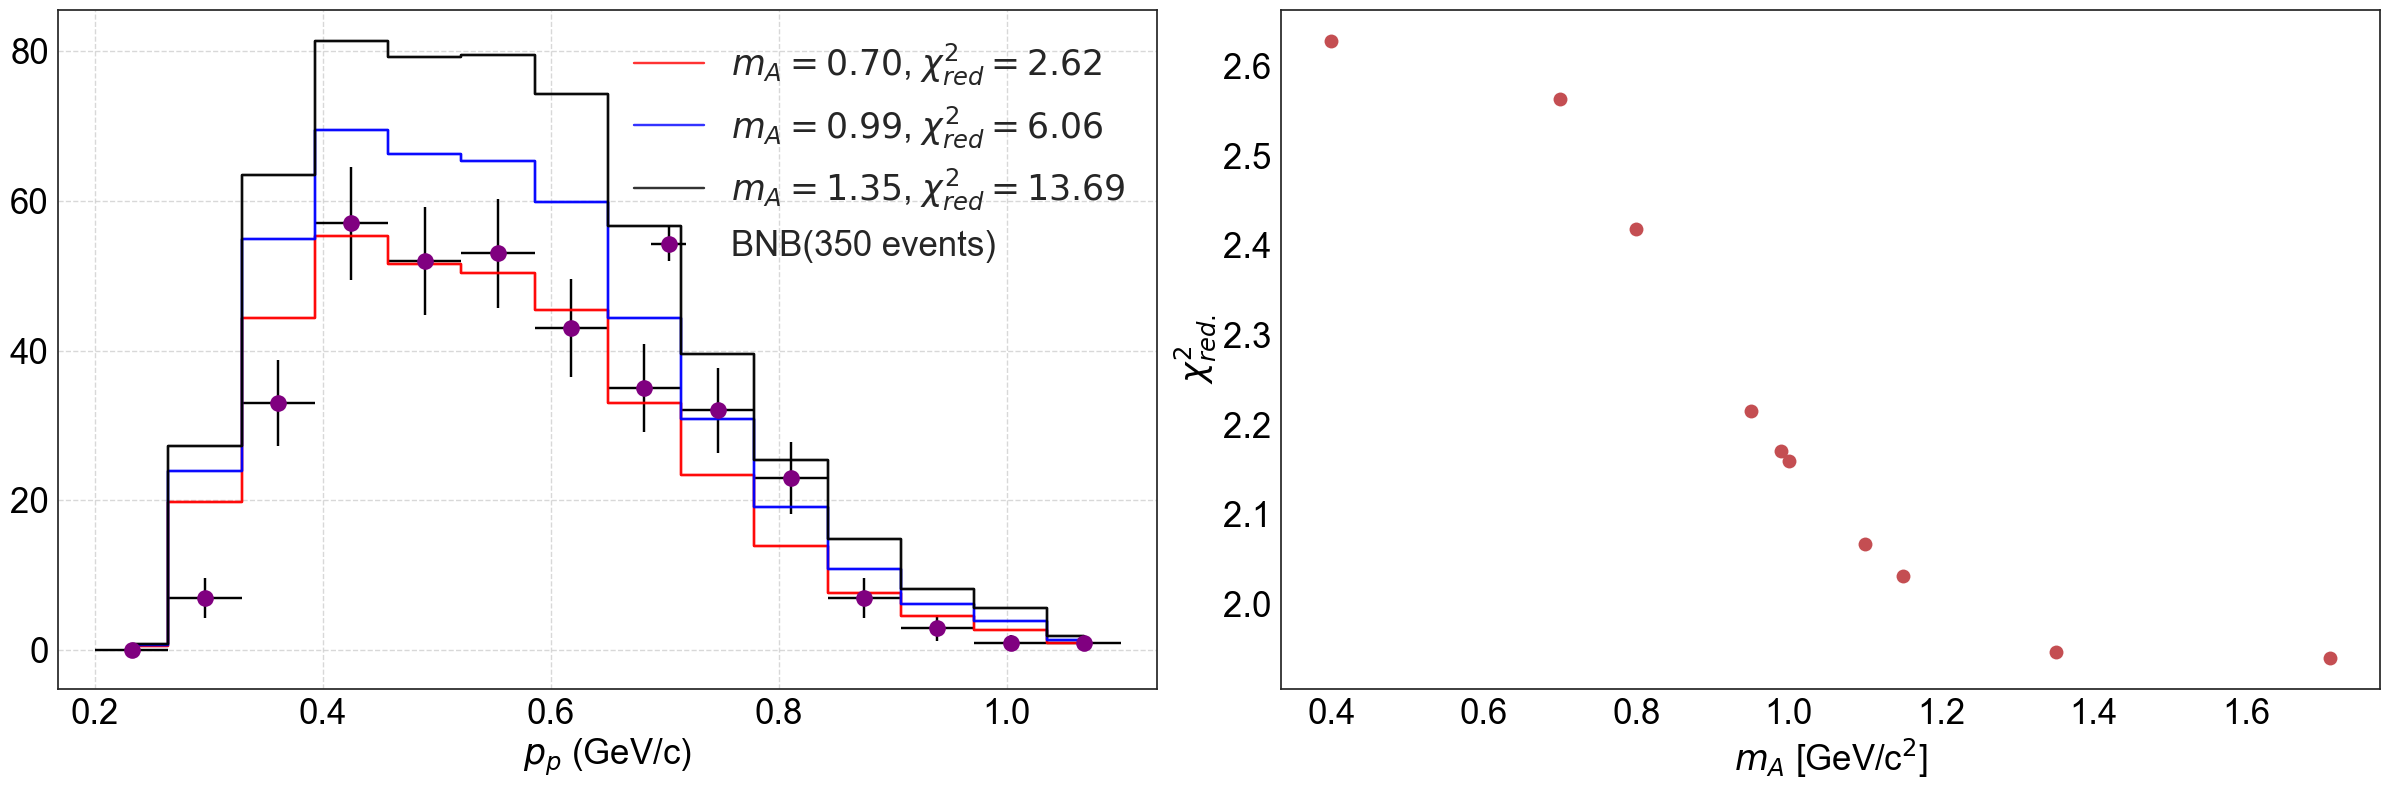

In [13]:
var,x_label = 'reco_Pp', r'$p_p$ (GeV/c)'
bins = linspace(0.2,1.1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.2,1.1)

fig=plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135','171'],['red','blue','black','forestgreen']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , ax=ax, overlay_scaling=overlay_scaling
                                                   , var=var
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , var=var
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , norm=len(data), do_draw=False
                                                   , overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()